# Breakout from Minatar

Import Minatar

In [3]:
!pip install minatar

Import libraries

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import numpy as np
from collections import namedtuple, deque
from minatar import Environment
import imageio
from IPython.display import Image, display
import io
from PIL import Image as PILImage #Using alias to avoid conflict with IPython.display.Image
import matplotlib.pyplot as plt

Seed

In [5]:
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
steps_done = 0

## Global parameters, functions and Classes

Global Parameters

In [1]:
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 5000
TAU = 0.01
LR = 1e-3
MEMORY_CAPACITY = 20000
NUM_EPISODES = 2000


Transition and Replay Memory

In [7]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward')) #As in the tutorial

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Now CNN instead of MLP

In [8]:
class DQN_CNN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN_CNN, self).__init__()
        c, h, w = input_shape
        self.conv1 = nn.Conv2d(c, 32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        convw = w - 2*2  # convoluciones sin padding
        convh = h - 2*2
        linear_input_size = convw * convh * 64
        self.fc1 = nn.Linear(linear_input_size, 128)
        self.fc2 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

Basic functions

In [9]:
def preprocess_state(state, device):
    # state: (H,W,C) → tensor (1,C,H,W)
    return torch.tensor(state, dtype=torch.float32, device=device).permute(2,0,1).unsqueeze(0)

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    n_actions = env.num_actions()
    if sample > eps_threshold:
        with torch.no_grad():
            q_values = policy_net(state)
            best_action = q_values.max(1).indices
            return best_action.view(1,1)
    else:
        return torch.tensor([[random.randint(0, n_actions-1)]], device=device, dtype=torch.long)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor([s is not None for s in batch.next_state], device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Environment

In [10]:
env = Environment('breakout')
env.seed(SEED)
n_actions = env.num_actions()
input_shape = env.state().shape  # (10,10,4)

Initializing the DQN

In [11]:
policy_net = DQN_CNN(input_shape[::-1], n_actions).to(device)
target_net = DQN_CNN(input_shape[::-1], n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.AdamW(policy_net.parameters(), lr=LR)
memory = ReplayMemory(MEMORY_CAPACITY)

episode_rewards = []
frames = []

## Training

Because it takes too long to train we propose two trainings that work:

The first one takes 30 minutes

The second one takes 1 hour and 20 minutes

Training SHORT

In [ ]:
NUM_EPISODES = 700

for episode in range(NUM_EPISODES):
    env.reset()
    state_raw = env.state()
    state = preprocess_state(state_raw, device)

    total_reward = 0
    done = False

    while not done:
        action_tensor = select_action(state)
        action = action_tensor.item()

        #In environment
        reward, done = env.act(action)  #Only unpack 2 values
        current_step_state_raw = env.state() #Get the new state after the action
        reward_tensor = torch.tensor([reward], device=device, dtype=torch.float32)

        if not done:
            next_state = preprocess_state(current_step_state_raw, device)
        else:
            next_state = None

        memory.push(state, action_tensor, next_state, reward_tensor)
        state = next_state
        total_reward += reward

        optimize_model()

        # Soft update target network
        with torch.no_grad():
            for target_param, policy_param in zip(target_net.parameters()
            , policy_net.parameters()):
                target_param.data.copy_(TAU * policy_param.data + (1.0 - TAU) * target_param.data)

        frames.append(current_step_state_raw) # Append the state after the action

    episode_rewards.append(total_reward)
    if episode % 100 == 0:
        avg_reward = sum(episode_rewards[-10:])/min(len(episode_rewards),10)
        print(f"Episode {episode} | Reward: {total_reward:.1f} | Avg(10): {avg_reward:.2f}")

Episode 0 | Reward: 0.0 | Avg(10): 0.00
Episode 100 | Reward: 0.0 | Avg(10): 0.80
Episode 200 | Reward: 0.0 | Avg(10): 0.80
Episode 300 | Reward: 1.0 | Avg(10): 1.70
Episode 400 | Reward: 4.0 | Avg(10): 2.70
Episode 500 | Reward: 6.0 | Avg(10): 4.20
Episode 600 | Reward: 5.0 | Avg(10): 4.70
Episode 700 | Reward: 7.0 | Avg(10): 6.10


Training LONG

In [12]:
import io

for episode in range(NUM_EPISODES):
    env.reset()
    state_raw = env.state()
    state = preprocess_state(state_raw, device)

    total_reward = 0
    done = False

    # Clear frames at the start of the last episode, or re-initialize it.
    # To avoid accumulating frames from all episodes, we only populate 'frames' for the final episode.
    if episode == NUM_EPISODES - 1:
        frames = [] # Re-initialize frames list for the final episode

    while not done:
        action_tensor = select_action(state)
        action = action_tensor.item()

        #In environment
        reward, done = env.act(action)  #Only unpack 2 values
        current_step_state_raw = env.state() #Get the new state after the action
        reward_tensor = torch.tensor([reward], device=device, dtype=torch.float32)

        if not done:
            next_state = preprocess_state(current_step_state_raw, device)
        else:
            next_state = None

        memory.push(state, action_tensor, next_state, reward_tensor)
        state = next_state
        total_reward += reward

        optimize_model()

        #Soft update target network
        with torch.no_grad():
            for target_param, policy_param in zip(target_net.parameters()
            , policy_net.parameters()):
                target_param.data.copy_(TAU * policy_param.data + (1.0 - TAU) * target_param.data)

        #Only append frames for the last episode
        if episode == NUM_EPISODES - 1:
            frames.append(current_step_state_raw)

    episode_rewards.append(total_reward)
    if episode % 100 == 0:
        avg_reward = sum(episode_rewards[-10:])/min(len(episode_rewards),10)
        print(f"Episode {episode} | Reward: {total_reward:.1f} | Avg(10): {avg_reward:.2f}")

Episode 0 | Reward: 0.0 | Avg(10): 0.00
Episode 100 | Reward: 0.0 | Avg(10): 0.80
Episode 200 | Reward: 0.0 | Avg(10): 0.80
Episode 300 | Reward: 1.0 | Avg(10): 1.70
Episode 400 | Reward: 4.0 | Avg(10): 2.70
Episode 500 | Reward: 6.0 | Avg(10): 4.20
Episode 600 | Reward: 5.0 | Avg(10): 4.70
Episode 700 | Reward: 7.0 | Avg(10): 6.10
Episode 800 | Reward: 11.0 | Avg(10): 7.50
Episode 900 | Reward: 11.0 | Avg(10): 7.20
Episode 1000 | Reward: 7.0 | Avg(10): 8.00
Episode 1100 | Reward: 0.0 | Avg(10): 8.50
Episode 1200 | Reward: 9.0 | Avg(10): 8.20
Episode 1300 | Reward: 20.0 | Avg(10): 6.50
Episode 1400 | Reward: 11.0 | Avg(10): 14.90
Episode 1500 | Reward: 6.0 | Avg(10): 11.90
Episode 1600 | Reward: 15.0 | Avg(10): 12.10
Episode 1700 | Reward: 3.0 | Avg(10): 9.40
Episode 1800 | Reward: 20.0 | Avg(10): 13.90
Episode 1900 | Reward: 4.0 | Avg(10): 5.90


Inspecting the Channels

Shape of sample_state: (10, 10, 4)


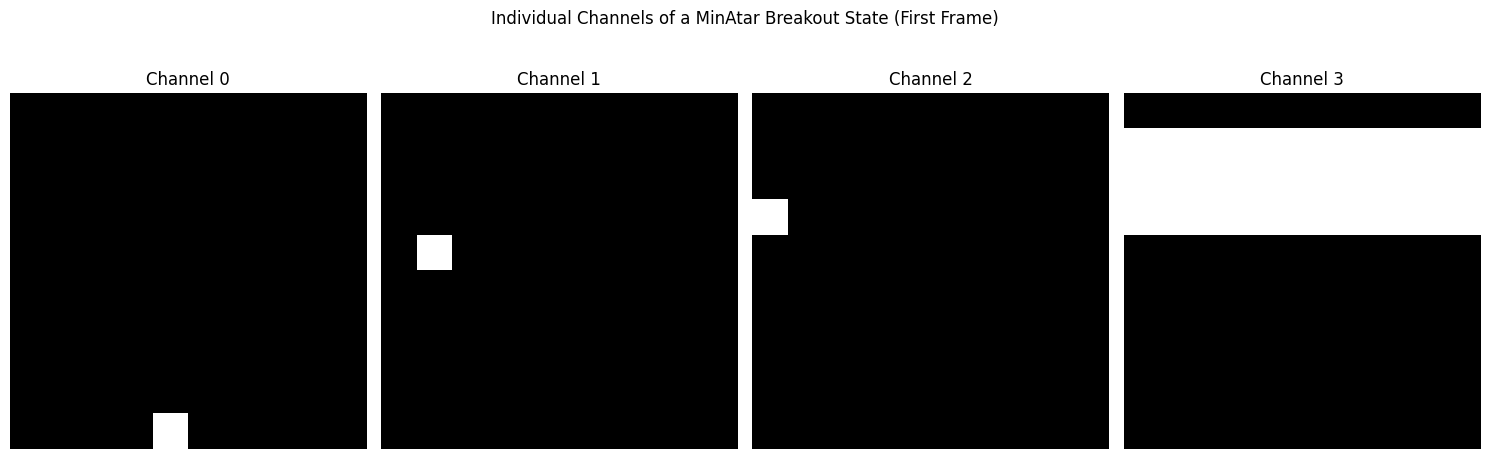

In [13]:
import matplotlib.pyplot as plt

#Take the first frame from the 'frames' list
#Make sure 'frames' list is not empty from previous runs.
if frames:
    sample_state = frames[0] #Get the first state

    print(f"Shape of sample_state: {sample_state.shape}")

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle('Individual Channels of a MinAtar Breakout State (First Frame)')

    for i in range(sample_state.shape[2]): #Iterate through the 4 channels
        ax = axes[i]
        #Convert boolean channel to int for visualization and then to PIL Image
        channel_image = PILImage.fromarray((sample_state[:, :, i] * 255).astype(np.uint8))
        ax.imshow(channel_image, cmap='gray', origin='upper') # Use 'gray' cmap for single channel
        ax.set_title(f'Channel {i}')
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #Adjust layout to prevent title overlap
    plt.show()
else:
    print("The 'frames' list is empty. Please ensure the training loop has run to populate it.")

Generate one GIF

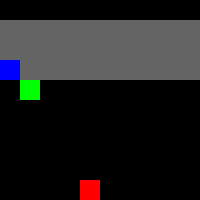

In [14]:
import io

gif_bytes = io.BytesIO()

SCALE_FACTOR = 20 #Upscale by 20x for better visibility

upscaled_frames = []
for frame_arr in frames:
    #Create an empty RGB image (10x10x3) initialized to black
    display_frame = np.zeros((10, 10, 3), dtype=np.uint8);

    #Define colors for each channel (assuming this mapping based on previous inspection)
    COLOR_PADDLE = [255, 0, 0]   # Red
    COLOR_BALL = [0, 255, 0]     # Green
    COLOR_BRICKS = [0, 0, 255]   # Blue
    COLOR_WALLS = [100, 100, 100] # Grey

    #Apply colors based on active pixels in each channel
    #Draw in an order that ensures foreground objects are visible
    #Walls (Channel 3)
    if np.any(frame_arr[:, :, 3]):
        display_frame[frame_arr[:, :, 3]] = COLOR_WALLS

    #Bricks (Channel 2)
    if np.any(frame_arr[:, :, 2]):
        display_frame[frame_arr[:, :, 2]] = COLOR_BRICKS

    #Ball (Channel 1)
    if np.any(frame_arr[:, :, 1]):
        display_frame[frame_arr[:, :, 1]] = COLOR_BALL

    #Paddle (Channel 0)
    if np.any(frame_arr[:, :, 0]):
        display_frame[frame_arr[:, :, 0]] = COLOR_PADDLE

    #Now, display_frame is an (H, W, 3) numpy array with distinct colors
    img = PILImage.fromarray(display_frame)
    resized_img = img.resize((img.width * SCALE_FACTOR, img.height * SCALE_FACTOR), PILImage.NEAREST)
    upscaled_frames.append(np.array(resized_img))

imageio.mimsave(gif_bytes, upscaled_frames, format='GIF', fps=10) #Reduced fps to 10
display(Image(data=gif_bytes.getvalue(), width=400)) #Keep display width for consistent rendering

### Gif

Training for the GIF

In [15]:
import io

#Re-initialize episode_rewards if starting training from scratch,
#or continue appending if this is a continuation.
#For this task, we assume continuation and just append.
NUM_EPISODES_2 = 10
for episode in range(NUM_EPISODES_2): #Continue from where the previous loop left off, or restart
    env.reset()
    state_raw = env.state()
    state = preprocess_state(state_raw, device)

    total_reward = 0
    done = False

    #Clear frames at the beginning of the first of the last four episodes
    if episode == NUM_EPISODES_2 - 4:
        frames = [] #Re-initialize frames list

    while not done:
        action_tensor = select_action(state)
        action = action_tensor.item()
        reward, done = env.act(action)
        current_step_state_raw = env.state()
        reward_tensor = torch.tensor([reward], device=device, dtype=torch.float32)

        if not done:
            next_state = preprocess_state(current_step_state_raw, device)
        else:
            next_state = None

        memory.push(state, action_tensor, next_state, reward_tensor)
        state = next_state
        total_reward += reward

        optimize_model()

        with torch.no_grad():
            for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
                target_param.data.copy_(TAU * policy_param.data + (1.0 - TAU) * target_param.data)

        if episode >= NUM_EPISODES_2 - 4:
            frames.append(current_step_state_raw)

    episode_rewards.append(total_reward)
    if episode % 100 == 0 or episode >= NUM_EPISODES_2 - 4:
        avg_reward = sum(episode_rewards[-10:])/min(len(episode_rewards),10)
        print(f"Episode {episode} | Reward: {total_reward:.1f} | Avg(10): {avg_reward:.2f}")

print(f"Finished training. Total frames collected: {len(frames)}")


Episode 0 | Reward: 21.0 | Avg(10): 14.80
Episode 6 | Reward: 21.0 | Avg(10): 15.50
Episode 7 | Reward: 6.0 | Avg(10): 14.00
Episode 8 | Reward: 16.0 | Avg(10): 13.50
Episode 9 | Reward: 3.0 | Avg(10): 11.70
Finished training. Total frames collected: 404


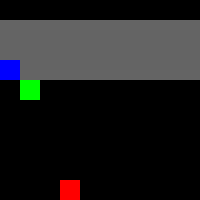

In [16]:
import io
gif_bytes = io.BytesIO()

SCALE_FACTOR = 20 #Upscale by 20x for better visibility

upscaled_frames = []
for frame_arr in frames:
    #Create an empty RGB image (10x10x3) initialized to black
    display_frame = np.zeros((10, 10, 3), dtype=np.uint8);

    #Define colors for each channel (assuming this mapping based on previous inspection)
    COLOR_PADDLE = [255, 0, 0]   #Red
    COLOR_BALL = [0, 255, 0]     #Green
    COLOR_BRICKS = [0, 0, 255]   #Blue
    COLOR_WALLS = [100, 100, 100] #Grey

    #Apply colors based on active pixels in each channel
    #Draw in an order that ensures foreground objects are visible
    #Walls (Channel 3)
    if np.any(frame_arr[:, :, 3]):
        display_frame[frame_arr[:, :, 3]] = COLOR_WALLS

    #Bricks (Channel 2)
    if np.any(frame_arr[:, :, 2]):
        display_frame[frame_arr[:, :, 2]] = COLOR_BRICKS

    #Ball (Channel 1)
    if np.any(frame_arr[:, :, 1]):
        display_frame[frame_arr[:, :, 1]] = COLOR_BALL

    #Paddle (Channel 0)
    if np.any(frame_arr[:, :, 0]):
        display_frame[frame_arr[:, :, 0]] = COLOR_PADDLE

    #Now, display_frame is an (H, W, 3) numpy array with distinct colors
    img = PILImage.fromarray(display_frame)
    resized_img = img.resize((img.width * SCALE_FACTOR, img.height * SCALE_FACTOR), PILImage.NEAREST)
    upscaled_frames.append(np.array(resized_img))

imageio.mimsave(gif_bytes, upscaled_frames, format='GIF', fps=10, loop=0) #Reduced fps to 10 and added loop=0
display(Image(data=gif_bytes.getvalue(), width=400)) #Keep display width for consistent rendering

In [17]:
output_filename = "breakout_animation.gif"

with open(output_filename, "wb") as f:
    f.write(gif_bytes.getvalue())

print(f"GIF successfully saved as '{output_filename}' in your Colab environment.")

GIF successfully saved as 'breakout_animation.gif' in your Colab environment.


## Metrics

### Metric 1

Number of Episodes registered: 2615


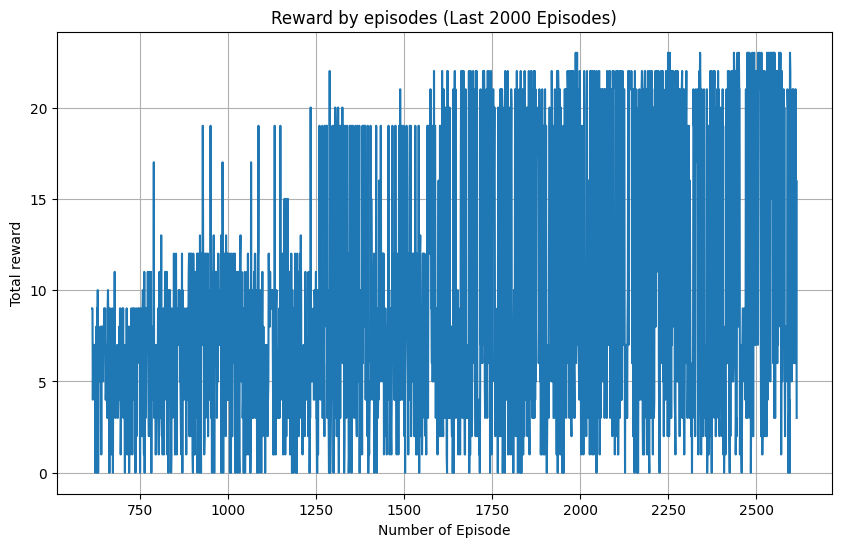

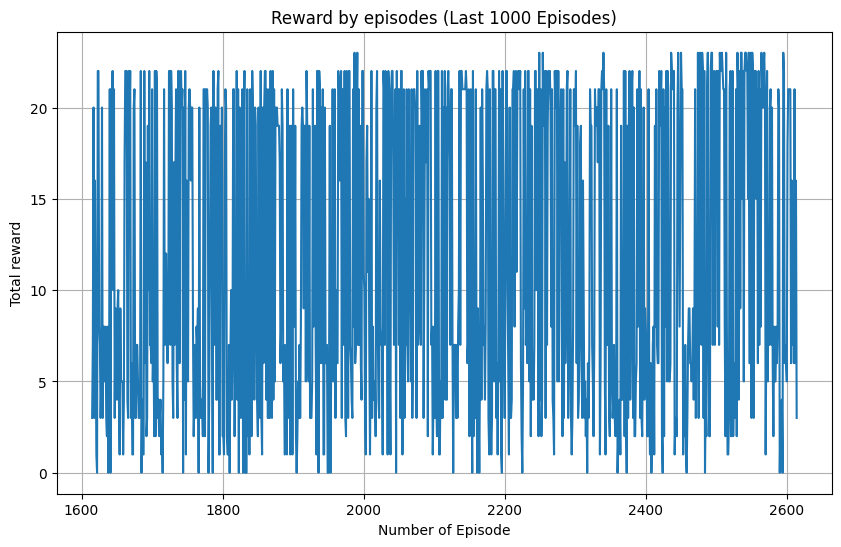

In [20]:
def plot_episode_rewards(rewards_list, num_episodes_to_plot=50):
    plt.figure(figsize=(10, 6))
    # Plot only the last N episodes if the list is very long
    if len(rewards_list) > num_episodes_to_plot:
        plt.plot(range(len(rewards_list) - num_episodes_to_plot, len(rewards_list)), rewards_list[-num_episodes_to_plot:])
        plt.title(f'Reward by episodes (Last {num_episodes_to_plot} Episodes)')
        plt.xlabel('Number of Episode')
    else:
        plt.plot(rewards_list)
        plt.title('Reward per Episode')
        plt.xlabel('Number of Episodes')
    plt.ylabel('Total reward')
    plt.grid(True)
    plt.show()

print(f"Number of Episodes registered: {len(episode_rewards)}")
plot_episode_rewards(episode_rewards, num_episodes_to_plot=2000)
plot_episode_rewards(episode_rewards, num_episodes_to_plot=1000)

### Metric 2

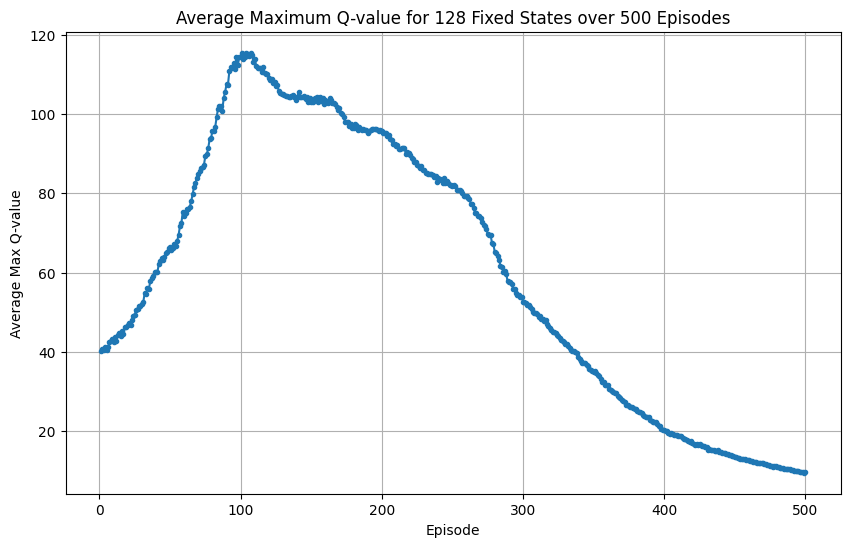

In [15]:
fixed_states = []
num_fixed_states = 128 #Number of fixed states

for _ in range(num_fixed_states):
    env.reset()
    for _ in range(random.randint(1, 5)): #Some random actions
        _, _ = env.act(random.randint(0, env.num_actions() - 1))
    fixed_states.append(preprocess_state(env.state(), device))

def calculate_avg_max_q(policy_net, states_batch, device):
    combined_states = torch.cat(states_batch)
    with torch.no_grad():
        q_values = policy_net(combined_states)
        max_q_values = q_values.max(1).values
    return max_q_values.mean().item()

NUM_EPISODES = 500

avg_max_q_per_episode = []

# Loop de entrenamiento
for episode in range(NUM_EPISODES):
    env.reset()
    state_raw = env.state()
    state = preprocess_state(state_raw, device)

    total_reward = 0
    done = False

    if episode == NUM_EPISODES - 1:
        frames = []

    while not done:
        action_tensor = select_action(state)
        action = action_tensor.item()

        reward, done = env.act(action)
        current_step_state_raw = env.state()
        reward_tensor = torch.tensor([reward], device=device, dtype=torch.float32)

        if not done:
            next_state = preprocess_state(current_step_state_raw, device)
        else:
            next_state = None

        memory.push(state, action_tensor, next_state, reward_tensor)
        state = next_state
        total_reward += reward

        optimize_model()

        #Soft update target network
        with torch.no_grad():
            for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
                target_param.data.copy_(TAU * policy_param.data + (1.0 - TAU) * target_param.data)

        if episode == NUM_EPISODES - 1:
            frames.append(current_step_state_raw)

    current_avg_max_q = calculate_avg_max_q(policy_net, fixed_states, device)
    avg_max_q_per_episode.append(current_avg_max_q)

    episode_rewards.append(total_reward)
    if episode % 100 == 0:
        avg_reward = sum(episode_rewards[-10:])/min(len(episode_rewards),10)
        print(f"Episode {episode} | Reward: {total_reward:.1f} | Avg(10): {avg_reward:.2f} | Avg Max Q: {current_avg_max_q:.2f}")

#Plot the avg_max_q_per_episode collected during the training loop
plt.figure(figsize=(10,6))
plt.plot(range(1, NUM_EPISODES + 1), avg_max_q_per_episode, marker='o', markersize=3)
plt.title(f"Average Maximum Q-value for {num_fixed_states} Fixed States over {NUM_EPISODES} Episodes")
plt.xlabel("Episode")
plt.ylabel("Average Max Q-value")
plt.grid(True)
plt.show()

### Metric 3

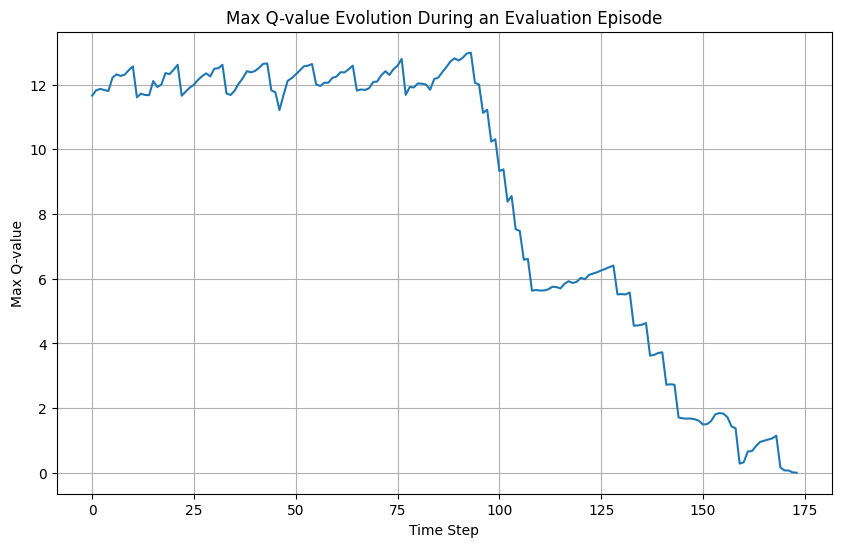

In [27]:
def visualize_value_function_episode(policy_net, env, device):
    env.reset()
    state_raw = env.state()
    state = preprocess_state(state_raw, device)
    done = False
    max_q_values_per_step = []
    step_count = 0
    while not done:
        with torch.no_grad():
            q_values = policy_net(state)
            max_q = q_values.max(1).values.item()
            max_q_values_per_step.append(max_q)

            #No exploration
            action = q_values.max(1).indices.item()

        _, done = env.act(action)
        state = preprocess_state(env.state(), device) if not done else None
        step_count += 1
    plt.figure(figsize=(10, 6))
    plt.plot(max_q_values_per_step)
    plt.title("Max Q-value Evolution During an Evaluation Episode")
    plt.xlabel("Time Step")
    plt.ylabel("Max Q-value")
    plt.grid(True)
    plt.show()
visualize_value_function_episode(policy_net, env, device)

### Metric 4

In [26]:
def evaluate_action_bias(policy_net, env, device, num_eval_episodes=10):
    left_actions_count = 0
    right_actions_count = 0
    #Actions 0, 1, 2, 3 are NOOP, LEFT, RIGHT, FIRE (standard MinAtar)
    ACTION_LEFT = 1
    ACTION_RIGHT = 2

    print(f"Evaluation of Biais over {num_eval_episodes} episodes...")
    for i in range(num_eval_episodes):
        env.reset()
        state_raw = env.state()
        state = preprocess_state(state_raw, device)
        done = False

        while not done:
            with torch.no_grad():
                q_values = policy_net(state)
                action = q_values.max(1).indices.item()

            if action == ACTION_LEFT:
                left_actions_count += 1
            elif action == ACTION_RIGHT:
                right_actions_count += 1

            _, done = env.act(action)
            state = preprocess_state(env.state(), device) if not done else None

    total_directional_actions = left_actions_count + right_actions_count
    if total_directional_actions > 0:
        left_ratio = left_actions_count / total_directional_actions
        right_ratio = right_actions_count / total_directional_actions
    else:
        left_ratio = 0
        right_ratio = 0

    print("\n--- Summary of directonnaly bias ---")
    print(f"Total 'LEFT' actions: {left_actions_count}")
    print(f"Total 'RIGHT' actions: {right_actions_count}")
    print(f"Ratio 'LEFT': {left_ratio:.2f}")
    print(f"Ratio 'RIGHT': {right_ratio:.2f}")
    if left_ratio > right_ratio:
        print("The Agent seems to have a preference for the 'LEFT'.")
    elif right_ratio > left_ratio:
        print("The Agent seems to have a preference for the 'RIGHT'.")
    else:
        print("No clear bias.")

evaluate_action_bias(policy_net, env, device, num_eval_episodes=100)

Evaluation of Biais over 100 episodes...

--- Summary of directonnaly bias ---
Total 'LEFT' actions: 2091
Total 'RIGHT' actions: 1935
Ratio 'LEFT': 0.52
Ratio 'RIGHT': 0.48
The Agent seems to have a preference for the 'LEFT'.
